# Week 5 Lab — Data Cleaning & Outlier Detection (Assignment Submission)

## Replicability notes (tested in a clean environment)
- **Python version:** 3.11+
- **How to recreate the environment:**
  1. Create and activate a virtual environment (e.g., `python -m venv venv`).
  2. Install dependencies: `pip install -r requirements.txt`
  3. Run this notebook from top to bottom.

- **Data files used in this notebook**
  - `pew_dataset.csv`
  - `billboard_dataset.csv`
  - `cars_dataset.csv`
  - `diabetes_dataset.csv`

> If you see an error on a different machine, record it here (what the error was + how you fixed it).  
> Example: missing package → run `pip install <package>` and regenerate `requirements.txt` using `pip freeze`.


# Data Tidying, Cleaning, and Outlier Detection

This notebook practices **data preprocessing** skills used in real analytics and machine learning workflows:
- Tidying data into a consistent “long” format
- Cleaning data (missing values, incorrect types, unnecessary rows)
- Detecting and handling outliers (visual + statistical methods)

The goal is to make the dataset **reliable, consistent, and reproducible** for downstream analysis.

Data preprocessing improves data quality so that analysis and models are trustworthy. In practice this means:

- **Tidying:** reshaping data into a consistent structure (e.g., one variable per column).
- **Cleaning:** fixing missing values, incorrect types, duplicates, and irrelevant rows.
- **Outlier detection:** identifying unusual values that can distort results.

Throughout this notebook, each section includes short explanations so someone new to the code can follow along.

## Data tidying

A tidy dataset usually follows these rules:
1. Each variable is a column.
2. Each observation is a row.
3. Each type of observational unit forms a table.

In this section we mainly use `pandas.melt()` (wide → long) and `pivot()` / `pivot_table()` (long → wide).

We will start with a small **PEW income by religion** dataset. The income ranges are currently stored as column names, which makes analysis harder.

Our job is to reshape the dataset so that **income range becomes a column value**, not a column header.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy import stats

from pathlib import Path

# -----------------------------
# File locations (do NOT change filenames)
# -----------------------------
DATA_DIR = Path("data/raw")  # <-- your CSVs are inside Week5/data/raw

PEW_PATH = DATA_DIR / "pew_dataset.csv"
BILLBOARD_PATH = DATA_DIR / "billboard_dataset.csv"
CARS_PATH = DATA_DIR / "cars_dataset.csv"
DIABETES_PATH = DATA_DIR / "diabetes_dataset.csv"

# Quick sanity check (should all be True)
print("PEW exists:", PEW_PATH.exists())
print("Billboard exists:", BILLBOARD_PATH.exists())
print("Cars exists:", CARS_PATH.exists())
print("Diabetes exists:", DIABETES_PATH.exists())

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


PEW exists: True
Billboard exists: True
Cars exists: True
Diabetes exists: True


### **PEW Research Dataset**

1. Start by Importing the dataset into a pandas dataframe.

2. Observe the dataset using the `loc`, `iloc`, `head`, or `tail` approaches

***What does not seem right in the above dataframe?***

3. Try to make the column headers represent a variable not a value. For that, use the `melt` function.

In [2]:
# 1) Read the PEW dataset
df_pew = pd.read_csv(PEW_PATH)
df_pew.head()

# 2) Quick inspection
print("Shape:", df_pew.shape)
print("Missing values per column:\n", df_pew.isna().sum())

# 3) Tidy the dataset (wide -> long)
# Income ranges are currently in column headers, so we melt them into a single 'income' column.
df_pew_tidy = df_pew.melt(
    id_vars=["religion"],
    var_name="income_range",
    value_name="respondents"
)

df_pew_tidy.head(10)


Shape: (11, 7)
Missing values per column:
 religion    0
 <$10k      3
 $10-20k    1
$20-30k     2
$30-40k     3
 $40-50k    2
$50-75k     1
dtype: int64


,religion,income_range,respondents
0,Agnostic,<$10k,NaN
1,Atheist,<$10k,NaN
2,Buddhist,<$10k,27.0
3,Catholic,<$10k,418.0
4,Dont know/refused,<$10k,NaN
5,Evangelical Prot,<$10k,575.0
6,Hindu,<$10k,1.0
7,Historically Black Prot,<$10k,228.0
8,Jehovahs Witness,<$10k,20.0
9,Jewish,<$10k,19.0


### **Billboard Dataset**

This dataset outlines data about the top hit songs on the Billboard list and the week from entrance that it was in the billboard with the ranking.

1. Read the dataset and store it in a pandas dataframe. Note that the usual utf-8 encoding does not work on this dataset. The reason behind this is that there might be characters that are not supported by `utf-8`.

The suggestion is to use for this dataset `unicode_escape` encoding. (converts all non-ASCII characters into their \uXXXX representations)

2. Observe the first few rows of the dataset.

***What is wrong with the above dataset?***

3. Let's, again, use the `melt` function to fix the general structure of the dataframe.

If we inspect the current dataframe. We find that it is structured in a better way than before. 

However, the ***Week*** column looks a bit ugly!

4. Let's try to place only the week number in that column without the extras surronding it.

5. Now let's inspect the ***Week*** column in the dataframe.

Next, let's try to find the date at which the song ranked the number that is shown per row.

6. To do that let's first think of the equation that is going to get us the relevant date at which the song ranked the *rth*.



*Timedeltas are absolute differences in times, expressed in difference units (e.g. days, hours, minutes, seconds). This method converts an argument from a recognized timedelta format / value into a Timedelta type.*


***What is the problem with the calculation above?***

7. Let's only keep necessary columns

8. How to rename your columns?

Display the dataframe

In the above dataframe, there are some *NaN* values. What are we going to do? <br/>
9. Apply quick data cleaning and then observe the dataset

In [3]:
# 1) Read the dataset (using unicode_escape as suggested in the instructions)
df_billboard_raw = pd.read_csv(BILLBOARD_PATH, encoding="unicode_escape")

# 2) Observe the data
df_billboard_raw.head()

# Common issues to look for:
# - extra spaces
# - wrong data types (e.g., rank as text)
# - missing values
print("Missing values:\n", df_billboard_raw.isna().sum())
print("\nDtypes:\n", df_billboard_raw.dtypes)

# 3) Demonstrate tidying with melt:
# Our file is already in a tidy-ish (long) format.
# To practice 'melt', we convert to a wide format first, then melt back to long.

sample = df_billboard_raw.sample(300, random_state=0).copy()

# Make a unique key per song
sample["song_id"] = sample["artist"].str.strip() + " - " + sample["track"].str.strip()

# Wide: each week becomes a separate column (values are ranks)
wide = sample.pivot_table(index="song_id", columns="week", values="rank", aggfunc="first")
wide = wide.reset_index()
wide.head()

# Melt back to long (tidy)
df_billboard_tidy = wide.melt(
    id_vars=["song_id"],
    var_name="week",
    value_name="rank"
).dropna(subset=["rank"])

# 4) Clean the 'week' column to keep only the week number
df_billboard_tidy["week_num"] = (
    df_billboard_tidy["week"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(int)
)

# 5) Clean rank (strip spaces, convert to numeric)
df_billboard_tidy["rank"] = (
    df_billboard_tidy["rank"]
    .astype(str)
    .str.strip()
)
df_billboard_tidy["rank"] = pd.to_numeric(df_billboard_tidy["rank"], errors="coerce")

# 6) Example: compute a (fake) chart-date using an entry date + week offset
# This is only for practicing Timedelta calculations.
entry_date = pd.Timestamp("2000-01-01")
df_billboard_tidy["chart_date"] = entry_date + pd.to_timedelta((df_billboard_tidy["week_num"] - 1) * 7, unit="D")

# 7) Keep only necessary columns
df_billboard_final = df_billboard_tidy[["song_id", "week_num", "rank", "chart_date"]].sort_values(["song_id", "week_num"])
df_billboard_final.head(10)


Missing values:
 artist      0
track       0
week        0
rank      195
dtype: int64

Dtypes:
 artist    str
track     str
week      str
rank      str
dtype: object


,song_id,week_num,rank,chart_date
2940,Artist_1 - Song_260,12,52,2000-03-18
6763,Artist_1 - Song_386,25,40,2000-06-17
11762,Artist_1 - Song_697,42,3,2000-10-14
12645,Artist_10 - Song_1476,45,1,2000-11-04
12940,Artist_10 - Song_1849,46,99,2000-11-11
13823,Artist_10 - Song_58,49,79,2000-12-02
9414,Artist_101 - Song_151,34,58,2000-08-19
5593,Artist_101 - Song_260,21,97,2000-05-20
5006,Artist_103 - Song_1468,19,82,2000-05-06
10299,Artist_104 - Song_1466,37,82,2000-09-09


## **Data Cleaning**

Data cleaning involves removing unwanted characters, imputing, or dropping missing values.

The decision is based on the dataset you have, and the information you can extract from the other columns.


Examples of data cleaning include cleaning:

1.   **Missing Data**
2.   **Irregular Data** (Outliers)
3.   **Unnecessary Data** — Repetitive Data, Duplicates and more
4.   **Inconsistent Data** — Capitalization, Addresses and more








### **Cars Data Set**

Start by reading the dataset related to car models: cars_dataset_10000_dirty.csv

In [4]:
# Read the Cars dataset
df_cars_raw = pd.read_csv(CARS_PATH)
df_cars_raw.head()

# The first row contains metadata / datatype hints (not actual data) -> remove it
df_cars = df_cars_raw.iloc[1:].copy()

# Convert numeric columns to numeric types
df_cars["MPG"] = pd.to_numeric(df_cars["MPG"], errors="coerce")
df_cars["Horsepower"] = pd.to_numeric(df_cars["Horsepower"], errors="coerce")

df_cars.head()

# Observe missing values
print("Missing values per column:\n", df_cars.isna().sum())

# Percentage of missing values per column
missing_pct = (df_cars.isna().mean() * 100).round(2)
print("\nMissing % per column:\n", missing_pct)

# Option A: drop rows with missing values (when missing % is small)
df_cars_drop_rows = df_cars.dropna().copy()
print("\nRows before:", len(df_cars), "Rows after dropping missing rows:", len(df_cars_drop_rows))

# Option B: drop columns (not ideal here because we would lose important variables)
df_cars_drop_cols = df_cars.dropna(axis=1).copy()
print("Columns before:", df_cars.shape[1], "Columns after dropping columns with NaN:", df_cars_drop_cols.shape[1])


Missing values per column:
 Car             0
MPG           500
Horsepower    500
Origin          0
dtype: int64

Missing % per column:
 Car           0.0
MPG           5.0
Horsepower    5.0
Origin        0.0
dtype: float64

Rows before: 10000 Rows after dropping missing rows: 9029
Columns before: 4 Columns after dropping columns with NaN: 2


First Row seems to be the datatype, we need to remove it

Let's observe the columns with null values.  Either by using the `isnull().sum()` function 

There aren't many missing values. Let's take a glimpse at the percentage of the missing values:

**HINT:** We'll need `Numpy` for the below task.

Around *0.19%* of the values are missing, which isn't a lot. Therefore, we might go with the option of dropping all the rows with null values.

Lets also check dropping the columns

Let's observe how many columns we lost

### **Cars Dataset - Filling in missing values automatically**

Another option is to try and fill in the missing values through imputations.

Let's take the `MPG` column for example. We can fill in the missing values with 0s through the following line of code:

`df_cars.fillna(0) `. 

However, this does not make much sense as there isn't MPG equal to 0. How about we plot the MPG column and if it follows a random distribution we can use the mean of the column to compute the missing values. Otherwise, we can use the median (if there is a skewed normal distribution). However, there might be a better way of imputation which is getting the median or the mean of the MPG of the cars with similar attributes.

If we observe the graph above, we can consider it in a way or another normally distributed. Therefore, we can impute the missing values using the mean.

To compute the mean we need numeric values. However the values in the dataframe are objects. Therefore, we need to change them to numerics so that we can compute them.

Now let's see what is the mean of the MPG column

We can use this mean to compute the missing values since the graph demonstarted a normal distribution

### **Car Dataset - Simple Imputer**

*SimpleImputer* is a `scikit-learn` class which is helpful in handling the missing data in the predictive model dataset. It replaces the `NaN` values with a specified placeholder.
It is implemented by the use of the `SimpleImputer()` method which takes the following arguments :

`missing_values` : The missing_values placeholder which has to be imputed. By default is NaN

`strategy` : The data which will replace the NaN values from the dataset. The strategy argument can take the values – ‘mean'(default), ‘median’, ‘most_frequent’ and ‘constant’.


Let's start by importing the `SimpleImputer` into our notebook

What we need to do are two essential steps:

1. fit the data (compute the mean / median / most freq)
2. transform the data (place the computed values in the NaN cells)

You can complete this section using the **Cars** (a.k.a. Auto) data sample in the course shell.

After imputation (missing values):
 MPG           0
Horsepower    0
dtype: int64


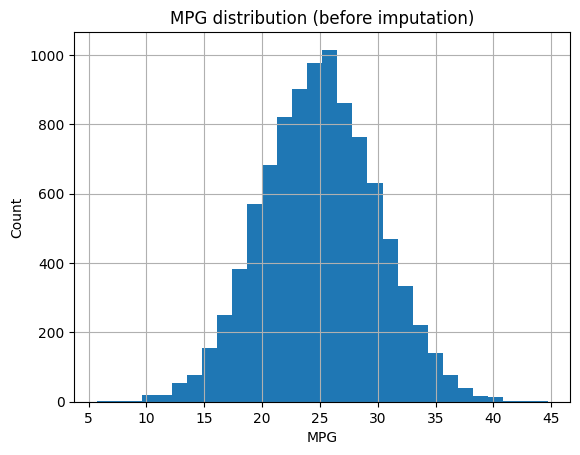

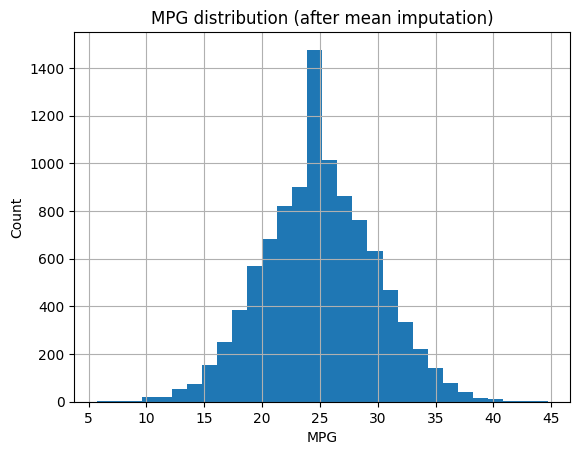

In [5]:
# SimpleImputer example (mean imputation for numeric columns)

# Work on a copy so we can compare before/after
df_cars_imp = df_cars.copy()

numeric_cols = ["MPG", "Horsepower"]
imputer = SimpleImputer(strategy="mean")

df_cars_imp[numeric_cols] = imputer.fit_transform(df_cars_imp[numeric_cols])

print("After imputation (missing values):\n", df_cars_imp[numeric_cols].isna().sum())

# Quick distribution check for MPG
plt.figure()
df_cars["MPG"].dropna().hist(bins=30)
plt.title("MPG distribution (before imputation)")
plt.xlabel("MPG")
plt.ylabel("Count")
plt.show()

plt.figure()
df_cars_imp["MPG"].hist(bins=30)
plt.title("MPG distribution (after mean imputation)")
plt.xlabel("MPG")
plt.ylabel("Count")
plt.show()


## **Outlier Detection** 


An Outlier is a data-item/object that deviates significantly from the rest of the (so-called normal)objects. They can be caused by measurement or execution errors. The analysis for outlier detection is referred to as outlier mining. There are many ways to detect the outliers, and the removal process is the data frame same as removing a data item from the panda’s data frame.


https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

Complete this section of the workshop using the Diabetes dataset that is included with the Scikit-Learn framework.



In [6]:
# Read the Diabetes dataset
df_diabetes_raw = pd.read_csv(DIABETES_PATH)
df_diabetes_raw.head()

print("Shape:", df_diabetes_raw.shape)
print("Missing values:\n", df_diabetes_raw.isna().sum())
print("\nSummary stats:\n", df_diabetes_raw.describe())

# For visualization/outlier detection, we will work on a numeric-only copy
df_diabetes = df_diabetes_raw.copy()

# Impute missing values (if any) with median (robust to outliers)
median_imputer = SimpleImputer(strategy="median")
df_diabetes[df_diabetes.columns] = median_imputer.fit_transform(df_diabetes)

df_diabetes.isna().sum()


Shape: (10000, 4)
Missing values:
 Glucose           79
BMI              105
BloodPressure      0
Age                0
dtype: int64

Summary stats:
            Glucose          BMI  BloodPressure           Age
count  9921.000000  9895.000000   10000.000000  10000.000000
mean    120.077529    29.981005      80.128064     48.317400
std      32.677633     6.107028      12.464713     18.060451
min       6.682807     7.747801      35.354861     18.000000
25%      99.523708    25.849817      71.803924     33.000000
50%     119.240865    29.913972      80.237658     48.000000
75%     139.986581    33.966005      88.241096     64.000000
max     500.000000    80.000000     200.000000     79.000000


Glucose          0
BMI              0
BloodPressure    0
Age              0
dtype: int64

### Outliers Visualization

#### Visualizing Outliers Using Box Plot
It captures the summary of the data effectively and efficiently with only a simple box and whiskers. Boxplot summarizes sample data using 25th, 50th, and 75th percentiles. One can just get insights(quartiles, median, and outliers) into the dataset by just looking at its boxplot.

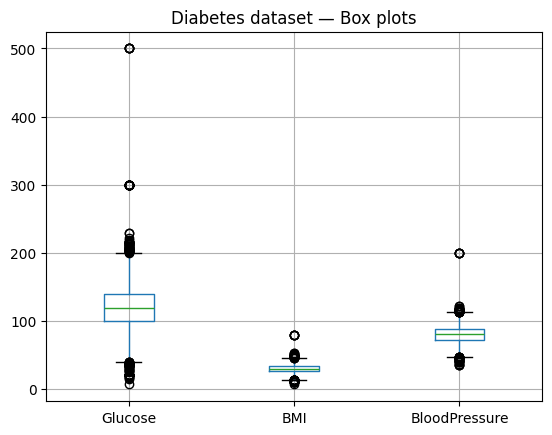

In [7]:
# Box plots help visually spot outliers quickly.
plt.figure()
df_diabetes.boxplot(column=["Glucose", "BMI", "BloodPressure"])
plt.title("Diabetes dataset — Box plots")
plt.show()


#### Visualizing Outliers Using ScatterPlot.

It is used when you have paired numerical data and when your dependent variable has multiple values for each reading independent variable, or when trying to determine the relationship between the two variables. In the process of utilizing the scatter plot, one can also use it for outlier detection.

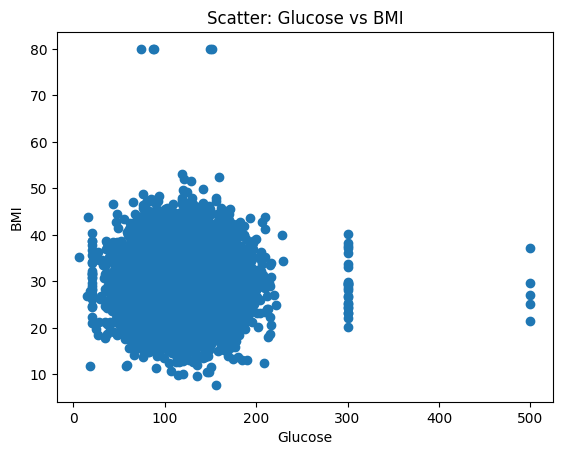

In [8]:
# Scatter plot (paired variables) — outliers often appear as isolated points.
plt.figure()
plt.scatter(df_diabetes["Glucose"], df_diabetes["BMI"])
plt.title("Scatter: Glucose vs BMI")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()


## Smooth out noise and identify outliers

Use the following algorithms and techniques presented in class:

- Binning
- Regression Smoothing
- Outlier Detection
- Clustering
- Discretization

#### Z-Score:
Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.
<br>
Zscore = (data_point -mean) / std. deviation



In [9]:
# Z-Score based outlier detection
# Compute z-scores for each numeric column
z_scores = np.abs(stats.zscore(df_diabetes[["Glucose", "BMI", "BloodPressure", "Age"]]))

z_df = pd.DataFrame(z_scores, columns=["z_Glucose", "z_BMI", "z_BP", "z_Age"])
z_df.head()


,z_Glucose,z_BMI,z_BP,z_Age
0,1.413146,0.485282,0.296035,1.346512
1,0.704952,0.653013,0.326337,0.571299
2,0.420246,1.502475,0.715950,0.702266
3,0.409315,0.684071,0.676974,1.180395
4,1.974277,1.072012,1.166125,0.037797


Now to define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

Rows where Z value is greater than 2

In [10]:
# Choose a threshold (commonly 3.0 for strong outliers; 2.0 is a softer threshold)
threshold = 3.0

outlier_mask_z = (z_df > threshold).any(axis=1)
print("Outliers detected (Z-Score > 3):", outlier_mask_z.sum())

df_outliers_z = df_diabetes.loc[outlier_mask_z].copy()
df_outliers_z.head()


Outliers detected (Z-Score > 3): 109


,Glucose,BMI,BloodPressure,Age
57,119.240865,53.160535,82.893593,28.0
67,130.505457,25.879244,200.000000,30.0
257,20.000000,26.712689,67.752723,53.0
421,300.000000,29.552370,71.510767,24.0
575,20.000000,29.003224,90.681411,23.0


#### IQR (Inter-Quartile Range)
Inter Quartile Range approach to finding the outliers is the most commonly used and most trusted approach used in the research field. <Br>
IQR = Quartile3 - Quartile1

In [11]:
# IQR method (example using Glucose)
q1 = df_diabetes["Glucose"].quantile(0.25)
q3 = df_diabetes["Glucose"].quantile(0.75)
iqr = q3 - q1

print("Q1:", q1, "Q3:", q3, "IQR:", iqr)


Q1: 99.72388061857124 Q3: 139.85845159397877 IQR: 40.13457097540753


To define the outlier base value is defined above and below dataset’s normal range namely Upper and Lower bounds, define the upper and the lower bound (1.5*IQR value is considered) :<br>
upper = Q3 + 1.5 * IQR <br>
lower = Q1 - 1.5 * IQR <br> 

In [12]:
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print("Lower bound:", lower)
print("Upper bound:", upper)

outlier_mask_iqr = (df_diabetes["Glucose"] < lower) | (df_diabetes["Glucose"] > upper)
print("Outliers detected by IQR (Glucose):", outlier_mask_iqr.sum())

df_outliers_iqr = df_diabetes.loc[outlier_mask_iqr].copy()
df_outliers_iqr.head()


Lower bound: 39.52202415545995
Upper bound: 200.06030805709005
Outliers detected by IQR (Glucose): 139


,Glucose,BMI,BloodPressure,Age
56,206.861906,42.700438,69.830833,64.0
60,37.280194,24.302210,92.758279,34.0
257,20.000000,26.712689,67.752723,53.0
421,300.000000,29.552370,71.510767,24.0
475,38.121253,27.624842,66.958533,45.0


- Removing the outliers:
For removing the outlier, one must follow the same process of removing an entry from the dataset using its exact position in the dataset because in all the above methods of detecting the outliers end result is the list of all those data items that satisfy the outlier definition according to the method used.

In [13]:
# Remove outliers (example: IQR-based removal on Glucose)
df_diabetes_no_outliers = df_diabetes.loc[~outlier_mask_iqr].copy()
print("Rows before:", len(df_diabetes), "Rows after removing IQR outliers:", len(df_diabetes_no_outliers))

# -----------------------------
# (Optional practice) Smooth/noise handling techniques
# -----------------------------

# 1) Binning (discretize Glucose into categories)
df_diabetes_no_outliers["Glucose_bin"] = pd.cut(df_diabetes_no_outliers["Glucose"], bins=5)

# 2) Regression smoothing (predict BMI from Glucose and check residuals)
X = df_diabetes_no_outliers[["Glucose"]].values
y = df_diabetes_no_outliers["BMI"].values
reg = LinearRegression().fit(X, y)
df_diabetes_no_outliers["BMI_pred"] = reg.predict(X)
df_diabetes_no_outliers["BMI_residual"] = df_diabetes_no_outliers["BMI"] - df_diabetes_no_outliers["BMI_pred"]

# 3) Clustering (2D clustering on Glucose & BMI)
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0)
df_diabetes_no_outliers["cluster"] = kmeans.fit_predict(df_diabetes_no_outliers[["Glucose", "BMI"]])

# 4) Discretization (Age group)
df_diabetes_no_outliers["Age_group"] = pd.cut(df_diabetes_no_outliers["Age"], bins=[17, 30, 45, 60, 80], labels=["18-30", "31-45", "46-60", "61-80"])

df_diabetes_no_outliers.head()


Rows before: 10000 Rows after removing IQR outliers: 9861


,Glucose,BMI,BloodPressure,Age,Glucose_bin,BMI_pred,BMI_residual,cluster,Age_group
0,74.077614,27.032420,76.438258,24.0,"(71.629, 103.717]",30.037615,-3.005195,0,18-30
1,97.127025,26.013521,76.060566,38.0,"(71.629, 103.717]",30.012795,-3.999275,0,31-45
2,106.393294,39.107205,71.204402,61.0,"(103.717, 135.805]",30.002818,9.104388,1,61-80
3,106.749038,25.824860,71.690200,27.0,"(103.717, 135.805]",30.002435,-4.177574,1,18-30
4,55.814619,23.468277,94.662746,49.0,"(39.38, 71.629]",30.057280,-6.589004,0,46-60


## Replicability check log (fill in after testing)

When you run this notebook on a different machine / clean environment, record:

- **Where it was tested:** (e.g., lab PC / friend's laptop / cloud notebook)
- **Steps used:** `pip install -r requirements.txt` then run all cells
- **Result:** Success ✅ / Errors ❌
- **If errors occurred:** paste the error message + the fix you applied

Example entry:
- Issue: `ModuleNotFoundError: No module named 'sklearn'`
- Fix: `pip install scikit-learn` then re-run `pip freeze > requirements.txt`
